In [130]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as k
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds

In [131]:
dataset = tfds.load(name='horses_or_humans', split=['train','test'], as_supervised = True)
train = dataset[0].batch(32, drop_remainder=True)
test = dataset[1].batch(32, drop_remainder=True)

In [51]:
# Load Horses + Humans dataset
dataset = tfds.load(name='horses_or_humans', split=['train','test'], as_supervised = True)
training = list(dataset[0].as_numpy_iterator())
X_train = np.array([training[i][0] for i in range(len(training))])
y_train = pd.Series([training[i][1] for i in range(len(training))], name="training targets")
testing = list(dataset[1].as_numpy_iterator())
X_test = np.array([testing[i][0] for i in range(len(testing))])
y_test = pd.Series([testing[i][1] for i in range(len(testing))], name="testing targets")

In [3]:
# Load MNIST dataset
dataset = k.datasets.fashion_mnist.load_data()
# Seperate dataset
training = dataset[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = dataset[1]
X_test = testing[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 0) | (y_test == 1)]
X_test = X_test[y_test.index]

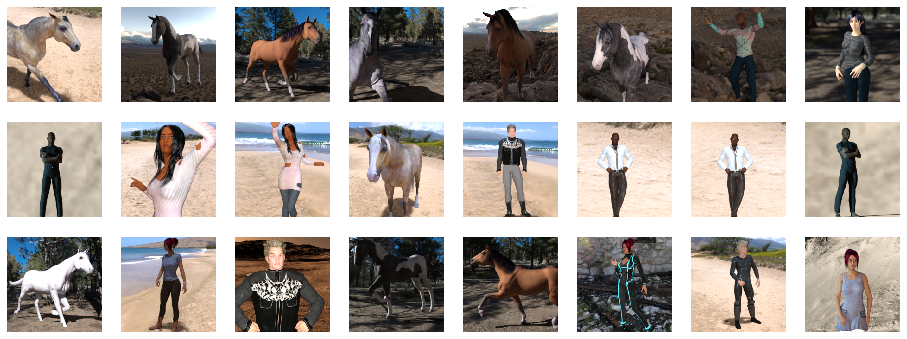

In [52]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

# Keras Model

In [152]:
initializer = "random_normal" # random_normal or glorot_uniform
keras_model = k.Sequential([ 
    k.layers.InputLayer(input_shape=(300,300,3)),
    k.layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer=initializer),
    k.layers.MaxPool2D(),
    k.layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer=initializer),
    k.layers.MaxPool2D(),
    k.layers.Flatten(),
    k.layers.Dense(16, activation="relu", kernel_initializer=initializer),
    k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
])
keras_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 170528)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                2728464   
_________________________________________________________________
dense_36 (Dense)             (None, 1)               

In [154]:
# Select only m samples for fast training time during debugging
m = 1000
X = X_train[:m,...].reshape((m, 300, 300, 3)).astype(float)
y = y_train[:m].values.reshape(1,m).astype(float)
# Compile model
keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss='binary_crossentropy')
# Train model
history = keras_model.fit(x=X, y=y.flatten(), epochs=10)

Epoch 1/10
32/32 [==============================] - 16s 485ms/step - loss: 0.5657
Epoch 2/10
32/32 [==============================] - 15s 483ms/step - loss: 0.5453
Epoch 3/10
32/32 [==============================] - 15s 484ms/step - loss: 0.5208
Epoch 4/10
32/32 [==============================] - 15s 484ms/step - loss: 0.5003
Epoch 5/10
32/32 [==============================] - 15s 483ms/step - loss: 0.4887
Epoch 6/10
32/32 [==============================] - 15s 483ms/step - loss: 0.4759
Epoch 7/10
32/32 [==============================] - 15s 483ms/step - loss: 0.4559
Epoch 8/10
32/32 [==============================] - 16s 484ms/step - loss: 0.4496
Epoch 9/10
32/32 [==============================] - 15s 481ms/step - loss: 0.4379
Epoch 10/10
32/32 [==============================] - 15s 480ms/step - loss: 0.4247


In [157]:
m = 100
X = X_test[:m,...].reshape((m, 300, 300, 3)).astype(float)
y = y_test[:m].values.reshape(1,m).astype(float)

predictions = keras_model.predict_classes(X)
accuracy_score(predictions, y.flatten())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.47

# Custom CNN

In [101]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [171]:
class Layer:
    """
    Interface for layers.
    """
    def __init__(self, input_shape: tuple, output_shape: tuple, trainable=True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.trainable = trainable
        
    def forward(self, A_prev):
        pass
    
    def backward(self, dZ):
        pass
    
    def update_params(self, learning_rate):
        pass
    
    def __str__(self):
        return self.__class__.__name__ + " " + str(self.output_shape)
    
    
class Dense(Layer):
    def __init__(self, neurons: int, input_shape: tuple, activation: str):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        neurons (N) -- number of neurons
        input_shape -- (N_prev, m)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        """
        output_shape = (neurons, input_shape[1])
        super().__init__(input_shape, output_shape)
        self.neurons = neurons
        self.activation = activation
        self.initialize_params()
        
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (N, N_prev)
        self.b -- Biases, numpy array of shape (N, 1)
        '''
        self.W = np.random.randn(self.neurons, self.input_shape[0]) * 0.01
        self.b = np.zeros((self.neurons,1))
        
        
    def forward(self, A_prev):
        """
        Implement the forward propagation for the dense layer with activation function

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        
        Defintions:
        self.cache -- tuple of values (A_prev, activation_cache) stored for computing backward propagation efficiently

        """
        Z = np.dot(self.W, A_prev) + self.b
        if self.activation == "sigmoid":
            A, activation_cache = sigmoid(Z)

        elif self.activation == "relu":
            A, activation_cache = relu(Z)

        assert (A.shape == (self.W.shape[0], A_prev.shape[1]))
        self.cache = (A_prev, activation_cache)

        return A
    
    def backward(self, dA):
        """
        Implement the backward propagation for the dense layer with activation function

        Arguments:
        dA -- post-activation gradient for current layer l 
       
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        
        Definitions:
        self.dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        self.db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, activation_cache = self.cache
        m = A_prev.shape[1]

        if self.activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif self.activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            
        self.dW = 1/m*np.dot(dZ, A_prev.T)
        self.db = 1/m*np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.W.T, dZ)

        return dA_prev
    
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Conv2D(Layer):
    def __init__(self, filters: int, filter_size: int, input_shape: tuple, padding="VALID", stride=1):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        filters (C) -- number of filters
        filter_size (f) -- size of filters
        input_shape -- (m, H, W, C)
        """
        output_shape = (input_shape[0], input_shape[1] - filter_size + 1, input_shape[2] - filter_size + 1, filters)
        super().__init__(input_shape, output_shape)
        self.filters = filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.initialize_params()
    
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (f, f, C_prev, n_C)
        self.b -- Biases, numpy array of shape (1, 1, 1, n_C)
        '''
        self.W = np.random.randn(self.filter_size, self.filter_size, self.input_shape[3], self.filters) * 0.01
        self.b = np.zeros((self.filters))
        

    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        
        Returns:
        Z -- conv output
        """
        
        # Perform convolution
        Z = tf.raw_ops.Conv2D(input=A_prev, filter=self.W, strides=[self.stride]*4, padding=self.padding)
        # Add bias
        Z = tf.raw_ops.BiasAdd(value=Z, bias=self.b)
        
        # Save information in "cache" for the backprop
        self.cache = A_prev
        # Return the output
        return Z.numpy()
    
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function
        
        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, H, W, C)
        
        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, H_prev, W_prev, C_prev)
                   
        Definitions:
        self.dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, C_prev, C)
        self.db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, C)
        """

        # Retrieve information from "cache"
        A_prev = self.cache
        
        dA_prev = tf.raw_ops.Conv2DBackpropInput(input_sizes = A_prev.shape, filter = self.W, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.dW = tf.raw_ops.Conv2DBackpropFilter(input = A_prev, filter_sizes = self.W.shape, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.db = tf.raw_ops.BiasAddGrad(out_backprop=dZ).numpy()
        return dA_prev
    
       
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db
        
class Maxpool(Layer):
    def __init__(self, input_shape, pool_size=2):
        self.ksize = [1, pool_size, pool_size, 1]
        self.strides = [1, pool_size, pool_size, 1]
        output_shape = (input_shape[0], input_shape[1]//pool_size, input_shape[2]//pool_size, input_shape[3])
        super().__init__(input_shape, output_shape, False)

        
    def forward(self, A_prev):
        Z = tf.raw_ops.MaxPool(input=A_prev, ksize=self.ksize, strides=self.strides, data_format='NHWC', padding="VALID").numpy()
        self.cache = (A_prev, Z)
        return Z
    
    def backward(self, dZ):
        A_prev, Z = self.cache
        dA_prev = tf.raw_ops.MaxPoolGrad(orig_input=A_prev, orig_output=Z, grad=dZ, ksize=self.ksize, strides=self.strides, padding="VALID", data_format='NHWC').numpy()
        return dA_prev

        
class ReLU(Layer):
    def __init__(self, input_shape):
        output_shape = input_shape
        super().__init__(input_shape, output_shape, False)
           
    def forward(self, Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        """

        A = np.maximum(0,Z)
        self.cache = Z 
        return A

    def backward(self, dA):
        """
        Implement the backward propagation for a single RELU unit.
        Arguments:
        dA -- post-activation gradient, of any shape
        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.cache
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.

        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0

        return dZ
    

class Flatten(Layer):
    def __init__(self, input_shape):
        m, *shape = input_shape
        output_shape = (np.prod(shape), m)
        super().__init__(input_shape, output_shape, False)
        
    def forward(self, A_prev):
        m, *shape = A_prev.shape
        self.cache = A_prev.shape
        return A_prev.flatten().reshape(m,np.prod(shape)).T
    
    def backward(self, dZ):
        return dZ.T.reshape(self.cache)
    
        
class Model:
    def __init__(self, layers: list):
        self.layers = layers
        self.parameters = dict()
        
    def fit(self, X, Y, epochs, learning_rate, verbose): 
        # Initialize parameters
        history = list()
        for epoch in range(epochs):
            # FORWARD PROP
            Z = X
            for layer in self.layers:
                Z = layer.forward(Z)
            
            # COST FUNCTION
            cost = compute_cost(Z, Y)
            history.append(cost)
            if verbose == 1:
                print("Cost epoch ", epoch, ": ", cost, sep="")

            # BACKWARD PROP
            dA = - (np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to AL
            
            for layer in reversed(self.layers):
                dA = layer.backward(dA)
            
            # UPDATE PARAMS
            for layer in self.layers:
                layer.update_params(learning_rate)

        return history
    
    def predict(self, X):
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)
        return Z
    
    def summary(self):
        print("-"*25)
        for layer in layers:
            print(layer)
            print("-"*25)
            
    def _cost(self, X, Y):
        Z = X
        for prop_layer in self.layers:
            Z = prop_layer.forward(Z)
        # COMPUTE COST
        return compute_cost(Z, Y)
    
    def gradcheck(self, X, Y, epsilon=1e-7, numlayers=None):
        self.approx_grads = []
        self.true_grads = []
        for layer in self.layers[:numlayers]:
            if not layer.trainable:
                continue
            for i in range(layer.W.size):
                i = np.unravel_index(i, layer.W.shape)
                Wi = layer.W[i]
                layer.W[i] = Wi + epsilon
                J1 = self._cost(X, Y)
                layer.W[i] = Wi - epsilon
                J2 = self._cost(X, Y)
                layer.W[i] = Wi
                self.approx_grads.append((J1-J2)/(2*epsilon))
                
            for i in range(layer.b.size):
                i = np.unravel_index(i, layer.b.shape)
                bi = layer.b[i]
                layer.b[i] = bi + epsilon
                J1 = self._cost(X, Y)
                layer.b[i] = bi - epsilon
                J2 = self._cost(X, Y)
                layer.b[i] = bi
                self.approx_grads.append((J1-J2)/(2*epsilon))
        
        # FORWARD PROP
        Z = X
        for prop_layer in self.layers:
            Z = prop_layer.forward(Z)
        # BACKWARD PROP
        dA = - (np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to AL

        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        
        for layer in self.layers[:numlayers]:
            if not layer.trainable:
                continue
            self.true_grads = np.concatenate((self.true_grads, layer.dW.flatten(), layer.db.flatten()))
        return np.sqrt(np.sum(np.square(self.true_grads-self.approx_grads)))/(np.sqrt(np.sum(np.square(self.true_grads)))+np.sqrt(np.sum(np.square(self.approx_grads))))
    

In [172]:
# Select only m samples for fast training time during debugging
m = 1
X = X_train[:m,...].reshape((m, 300, 300, 3)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(1, 3, (None, 300, 300, 3)),
    ReLU((None, 298, 298, 1)),
    Maxpool((None, 298, 298, 1)),
    Flatten((None, 149, 149, 1)),
    Dense(1, (22201, None), "relu"),
    Dense(1, (1, None), "sigmoid")
]

# Create and train modela
model = Model(layers)
model.gradcheck(X,y)

1.9285124645550787e-09

In [ ]:
# Select only m samples for fast training time during debugging
m = 100
X = X_train[:m,...].reshape((m, 300, 300, 3)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(32, 3, (None, 300, 300, 3)),
    ReLU((None, 298, 298, 32)),
    Maxpool((None, 298, 298, 32)),
    Conv2D(32, 3, (None, 149, 149, 32)),
    ReLU((None, 147, 147, 32)),
    Maxpool((None, 147, 147, 32)),
    Flatten((None, 73, 73, 32)),
    Dense(16, (170528, None), "relu"),
    Dense(16, (16, None), "relu"),
    Dense(1, (16, None), "sigmoid")
]

# Create and train modela
model = Model(layers)
history = model.fit(X, y, epochs=10, learning_rate=0.05, verbose=1)

Cost epoch 0: 0.6931727936509011
Cost epoch 1: 0.692376842014251
Cost epoch 2: 0.6878163280316492
Cost epoch 3: 0.7485672768312662
Cost epoch 4: 0.69420235927035
Cost epoch 5: 0.6988961275709477
Cost epoch 6: 0.6928388902516365
Cost epoch 7: 0.6926623460035413


In [183]:
m = 100
X = X_test[:m, ...].reshape((m, 300, 300, 3)).astype(float)
y = y_test[:m].values.reshape(1,m).astype(float)

predictions = model.predict(X)
accuracy_score(y.flatten(), predictions.flatten().round())

0.7